# Regularyzacja w modelu regresji - zbiór `longley`

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import sklearn.metrics as metrics

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Zadanie - `longley`

Zbiór danych `longley` zawiera różne zmienne makroekonomiczne w USA, o których wiadomo, że są wysoce współliniowe.

`GNPDEFL` GNP implicit price deflator (1954=100)

`GNP` Gross National Produc

`UNEMP` number of unemployed.

`ARMED` number of people in the armed forces.

`POP` ‘noninstitutionalized’ population ≥ 14 years of age.

`YEAR` the year (time).

`TOTEMP` number of people employed.

1. Podziel zbiór na częśc treningową i testową w stosunku 7:3


2. Dopasuj na danych treningowych model regresji liniowej, w którym zmienną zależną jest zmienna `TOTEMP` a pozostałe cechy zmiennymi niezależnymi. Wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
   - błąd średniokwadratowy,
   - medianę błędu bezwzględnego.
   
    
3. Dopasuj na danych treningowych model regresji grzbietowej:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy,
      - medianę błędu bezwzględnego.    


4. Dopasuj na danych treningowych model regresji Lasso:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy,
      - medianę błędu bezwzględnego.
   
5. Dopasuj na danych treningowych model regresji wielomianowej z regularyzacją grzbietową:
   - znajdź optymalny stopień wielomianu i optymalną wartość parametru $\alpha$,
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy,
      - medianę błędu bezwzględnego.

6. Dopasuj na danych treningowych model regresji wielomianowej z regularyzacją Lasso:
   - znajdź optymalny stopień wielomianu i optymalną wartość parametru $\alpha$,
   - wyznacz jakość predykcji modelu obliczając na zbiorze testowym:
      - błąd średniokwadratowy,
      - medianę błędu bezwzględnego.

Rozwiązując powyższe zadanie staraj się automatyzować swoją analizę, tj. napisz funkcje:
- `pred_scores`, która zwraca słownik/ramkę danych miar predykcji dla zbudowanego modelu;
- `grid_search_alpha`, która znajduje optymalną wartość $\alpha$ dla modelu regresji z regularyzacją Ridge lub Lasso;
- `plot_coef_vs_alpha`, która służy do tworzenia wykresu zmian wartości współczynników w zależności od wzrostu parametru $\alpha$;
- `grid_search_power_and_alpha`, która znajduje optymalny stopień wielomianu oraz parametr $\alpha$ dla regresji wielomianowej z regularyzacją Ridge lub Lasso.

Przygotuj tak analizę aby na koniec przedstawić wszystkie wyniki w jednej tabeli.

In [2]:
longley = sm.datasets.longley.load_pandas()
longley.data.head()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0


In [3]:
#zmienna niezależne i zależna
X, y = longley.data.iloc[:, longley.data.columns != 'TOTEMP'], longley.data['TOTEMP']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) #podział na część treningową i testową

In [5]:
#funkcja licząca miary dla modelu
def pred_scores(model, X, y):
    mse = metrics.mean_squared_error(y_true=y, y_pred=model.predict(X))
    mae = metrics.median_absolute_error(y_true=y, y_pred=model.predict(X))

    results = {}
    results['mse'] = mse
    results['mae'] = mae
    return results

In [6]:
#funkcja mająca znaleźć najlepszą alphę w regresji ridge czy lasso za pomocą kroswalidacji (zwraca najlepszą alphę)
def grid_search_alpha(model,X,y,params,scoring,cv = 10):
  grid = GridSearchCV(
      make_pipeline(
          StandardScaler(),
          model
      ),
      params,
      scoring = scoring,
      cv = cv)
  grid.fit(X,y)
  return grid.best_params_

In [7]:
models = {}
#miary dla liniowego
models['linear'] = pred_scores(LinearRegression().fit(X_train,y_train),X_test,y_test)
#optymalna alpha dla ridge
best_alpha_ridge = grid_search_alpha(Ridge(),X_train,y_train,{'ridge__alpha':np.linspace(0.00001,0.01,100)},
                                     scoring = 'neg_mean_squared_error',cv = 10)
#ridge z najlepszym parametrem
ridge = make_pipeline(
          StandardScaler(),
          Ridge(best_alpha_ridge['ridge__alpha']))

#miary dla ridge
models['ridge_%.3g' % best_alpha_ridge['ridge__alpha']] = pred_scores(ridge.fit(X_train,y_train),X_test,y_test)
#optymalna alpha dla lasso
best_alpha_lasso = grid_search_alpha(Lasso(max_iter = 10000),X_train,y_train,{'lasso__alpha':np.linspace(0.00001,2,100)},
                                     scoring = 'neg_mean_squared_error',cv = 10)
#lasso z najlepszym parametrem
lasso = make_pipeline(
          StandardScaler(),
          Lasso(best_alpha_lasso['lasso__alpha']))
#miary dla lasso
models['lasso_%.3g' % best_alpha_lasso['lasso__alpha']] = pred_scores(lasso.fit(X_train,y_train),X_test,y_test)

In [8]:
ridge["ridge"].coef_

array([  403.36872194, -4602.38766276, -1855.25400543,  -626.73563866,
        -280.6002966 ,  9429.01842101])

In [9]:
pd.DataFrame(models)

,linear,ridge_0.00112,lasso_0.727
mse,382728.088775,90491.322675,99652.066428
mae,329.053655,218.861221,106.264359


In [10]:
#funkcja do stworzenia wykresu zmiany wartości współczynnika beta w zależności od zmiany alpha
def plot_coef_vs_alpha(model_name, min_alpha, max_alpha, poly_degree=1):
    alpha_vec =  np.linspace(min_alpha, max_alpha, 100)

    if (model_name == 'lasso'):
        model = Lasso(max_iter=10000)
    elif(model_name == 'ridge'):
        model = Ridge()

    coefs = []
    for a in alpha_vec:
        model.alpha = a

        model_reg = make_pipeline(
            PolynomialFeatures(poly_degree),
            StandardScaler(),
            model
        )

        model_reg.fit(X_train, y_train)
        coefs.append(model_reg.named_steps[model_name].coef_[1:])

    plt.plot(alpha_vec, coefs)
    plt.plot([np.min(alpha_vec), np.max(alpha_vec)], [0, 0], '-.', color = 'black')
    plt.xlabel('alpha')
    plt.ylabel('coefficients')
    plt.legend(X_train.columns)
    plt.show()

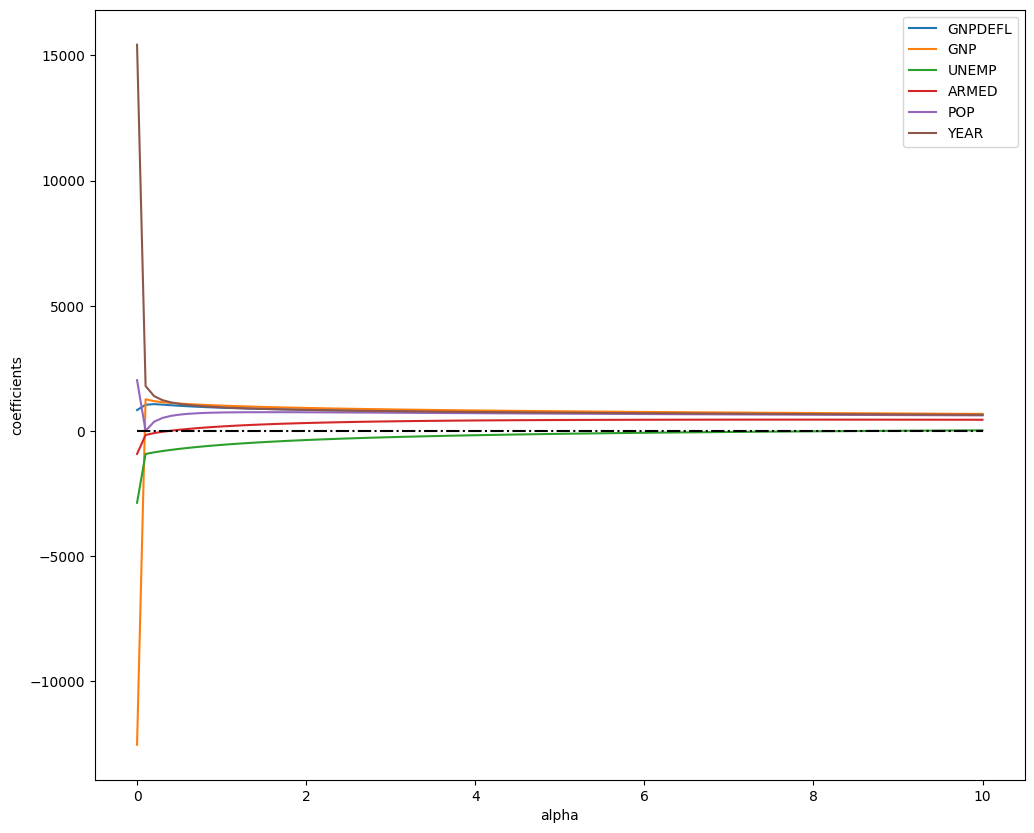

In [11]:
plot_coef_vs_alpha('ridge',0,10,1) #schodzą do 0

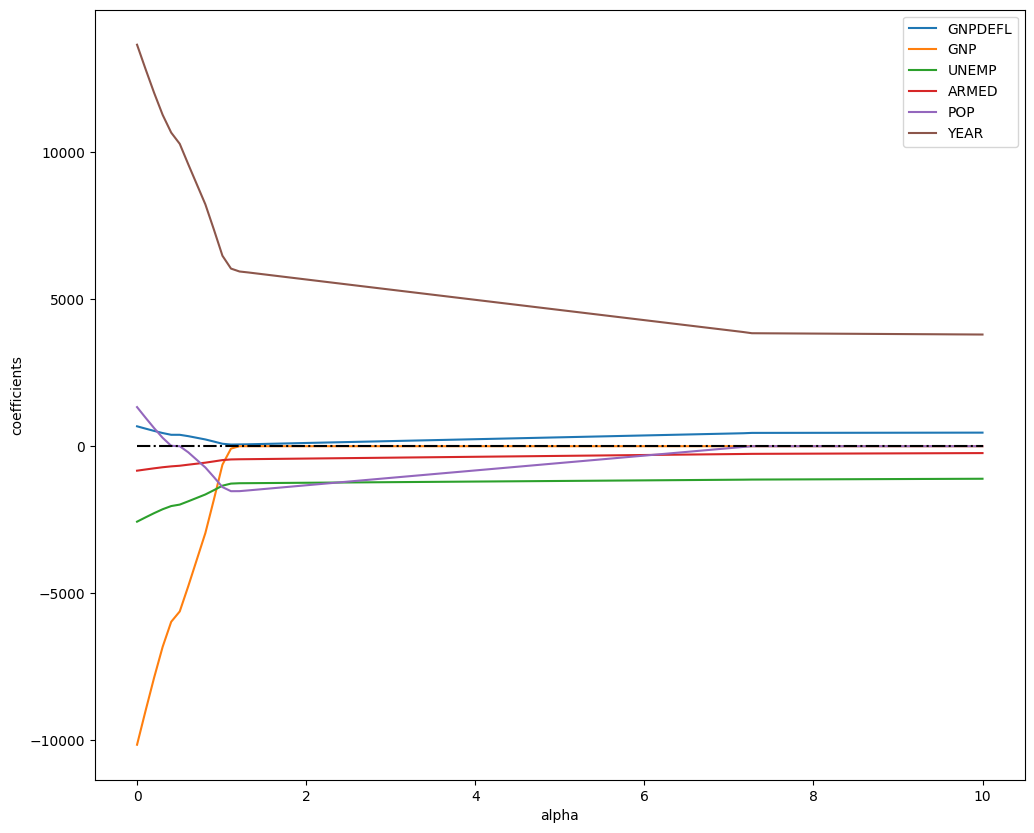

In [12]:
plot_coef_vs_alpha('lasso',0,10,1) #osiągają 0 jeden po drugim wraz ze wzrostem alphy

In [13]:
#funkcja do znajdywania najlepszego zestawu parametrów degree i alpha
def grid_search_power_and_alpha(model,X,y,params,scoring,cv = 10):
  grid = GridSearchCV(
      make_pipeline(
          PolynomialFeatures(),
          StandardScaler(),
          model
      ),
      params,
      scoring = scoring,
      cv = cv)
  grid.fit(X,y)
  return grid.best_params_

In [14]:
models2 = {}
#znajdujemy najlepsze parametry modelu dla ridge
best_params_ridge = grid_search_power_and_alpha(
    model = Ridge(),
    X = X_train,
    y=y_train,
    params = {
        'ridge__alpha':np.linspace(0.00001, 0.01, 100),
        'polynomialfeatures__degree':np.arange(1,5)
    },
    scoring = 'neg_mean_squared_error'
)

In [15]:
best_params_ridge #najlepsze parametry

{'polynomialfeatures__degree': 1, 'ridge__alpha': 0.0011200000000000001}

In [16]:
#ridge polynomial z najlepszym zestawem parametrów
ridge = make_pipeline(
          PolynomialFeatures(best_params_ridge['polynomialfeatures__degree']),
          StandardScaler(),
          Ridge(best_params_ridge['ridge__alpha'])
)
#miary dla ridge
models2['ridge_%.3g_%d' % (best_params_ridge['ridge__alpha'],
                       best_params_ridge['polynomialfeatures__degree'])] = pred_scores(ridge.fit(X_train,y_train),X_test,y_test)


In [17]:
#znajdujemy najlepsze parametrey modelu dla lasso
best_params_lasso = grid_search_power_and_alpha(
    model = Lasso(max_iter = 10000),
    X = X_train,
    y=y_train,
    params = {
        'lasso__alpha':np.linspace(0.00001, 2, 100), #parametr szukam między 6 a 8, bo wcześniej alpha z tego przedziału dawała najlepsze wyniki
        'polynomialfeatures__degree':np.arange(1,5)
    },
    scoring = 'neg_mean_squared_error'
)

In [18]:
#lasso polynomial z najlepszym zestawem parametrów
lasso = make_pipeline(
          PolynomialFeatures(best_params_lasso['polynomialfeatures__degree']),
          StandardScaler(),
          Lasso(best_params_lasso['lasso__alpha'])
)
#miary dla lasso
models2['lasso_%.3g_%d' % (best_params_lasso['lasso__alpha'],
                       best_params_lasso['polynomialfeatures__degree'])] = pred_scores(lasso.fit(X_train,y_train),X_test,y_test)

In [19]:
#wyniki końcowe - polynomial nie jest nam potrzebne bo degree=1 w połączeniu i z ridge i lasso
results = pd.concat([pd.DataFrame(models),pd.DataFrame(models2)],axis =1,sort = False)
results

,linear,ridge_0.00112,lasso_0.727,ridge_0.00112_1,lasso_0.727_1
mse,382728.088775,90491.322675,99652.066428,90491.322675,99652.066428
mae,329.053655,218.861221,106.264359,218.861221,106.264359
